PART 4 : MODELLING

Data was split using 70 - 30 rule, individuals to be in the train set and those to be in the test set were randomly selected.

Significant imbalance between classes: {Not Alert: 0.67, Alert: 0.33} The not alert examples include frames labelled as both low vigilance and drowsy.


In [ ]:
!pip install keras-tuner

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, accuracy_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
from kerastuner.tuners import RandomSearch
import kerastuner as kt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# Load data
frames_1_5 = pd.read_csv('frames_1_5.csv')
frames_13_18 = pd.read_csv('frames_13_18.csv')
frames_25_30 = pd.read_csv('frames_25_30.csv')

In [ ]:
# Preview data sets
frames_1_5.head()

,EAR,MAR,MOE,PUC,labels,individuals,NORM_EAR,NORM_MAR,NORM_MOE,NORM_PUC
0,0.335835,0.045935,0.136779,0.528916,0,1,0.039503,1.421065,1.167637,0.272911
1,0.253415,0.027255,0.107550,0.395299,0,1,-1.416127,-0.023263,0.496044,-1.476584
2,0.381109,0.018006,0.047247,0.561826,0,1,0.839105,-0.738322,-0.889483,0.703824
3,0.364033,0.019026,0.052265,0.546248,0,1,0.537518,-0.659480,-0.774199,0.499849
4,0.360476,0.067932,0.188450,0.541384,0,1,0.474697,3.121770,2.354840,0.436160


In [ ]:
frames_25_30['labels'].value_counts()

1    316
0    316
Name: labels, dtype: int64

In [ ]:
# Preview data sets
frames_13_18.head()

,EAR,MAR,MOE,PUC,labels,individuals,NORM_EAR,NORM_MAR,NORM_MOE,NORM_PUC
0,0.275309,0.016793,0.060997,0.461757,0,13,-1.472587,-1.401509,-1.395918,-1.415283
1,0.303325,0.134450,0.443253,0.498823,0,13,0.271834,0.797101,0.829263,0.522114
2,0.306427,0.090308,0.294714,0.505097,0,13,0.464930,-0.027757,-0.035409,0.850004
3,0.310777,0.125623,0.404223,0.489660,0,13,0.735822,0.632165,0.602064,0.043164
4,0.318539,0.047389,0.148770,0.515814,0,13,1.219064,-0.829776,-0.884979,1.410191


In [ ]:
# Combine data frames
all_frames = pd.concat([frames_13_18, frames_25_30])
#all_frames = frames_25_30

In [ ]:
# Shape of data
all_frames.shape

(2528, 10)

In [ ]:
# List of individuals in dataframes
unique_ind = all_frames['individuals'].unique()
unique_ind

array([13, 14, 15, 16, 17, 18, 25, 29])

In [ ]:
# Split data into train sets. Using an 70-30 rule, randomly select individuals to be in the train and test sets
num_train = int(round(len(unique_ind)*0.7, 0))
train_ind = random.sample(list(unique_ind), num_train)
test_ind = list(set(unique_ind) - set(train_ind))

# Create train and test sets
train = all_frames[all_frames['individuals'].isin(train_ind)]
test = all_frames[all_frames['individuals'].isin(test_ind)]

In [ ]:
print(train.shape)
print(test.shape)

(1896, 10)
(632, 10)


In [ ]:
# Split train and test sets into features and labels
x_train = train.drop(['individuals','labels'], axis=1).iloc[:, 4:]
x_test = test.drop(['individuals','labels'], axis=1).iloc[:, 4:]
y_train = train['labels']
y_test = test['labels']

In [ ]:
# Define function to estimate individual status based on previous and successive frames
def average(y_pred):
  for i in range(len(y_pred)):
    if i%158 == 0 or (i+1) % 158 == 0:
      pass
    else:
      average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
      if average >= 0.5:
        y_pred[i] = 1
      else:
        y_pred[i] = 0
  return y_pred

In [ ]:
# Distribution of classes in train and test
y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: labels, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.5
0    0.5
Name: labels, dtype: float64

## Random Forest

In [ ]:
# Initialize random forest model with base parameters
random_forest_model = RandomForestClassifier()
# Fit model
random_forest_model.fit(x_train, y_train)
# Make predictions
rand_pred = random_forest_model.predict(x_test)


In [ ]:
# Evaluate model
print(classification_report(y_test, average(rand_pred)))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       316
           1       0.73      0.73      0.73       316

    accuracy                           0.73       632
   macro avg       0.73      0.73      0.73       632
weighted avg       0.73      0.73      0.73       632



In [ ]:
#Get roc_auc sore
rand_prob = random_forest_model.predict_proba(x_test)[:,1]
print('ROC_AUC: ', roc_auc_score(y_test, rand_prob))

ROC_AUC:  0.6981202932222399


Text(0, 0.5, 'True Positive rate')

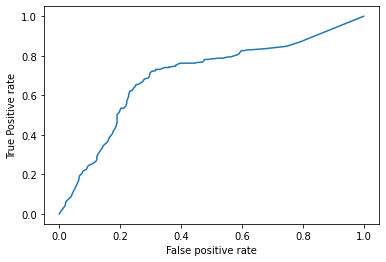

In [ ]:
# Plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, rand_prob)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')

The roc_auc score is pretty low, which explain the roc_curve above. The model is unable to distinguish between the two classes.

In [ ]:
# Define parameter grid for parameter tuning
param_grid_rand = {
    'max_depth': np.arange(80, 200, 10),
    'min_samples_leaf': [2,3],
    'n_estimators': [100, 200, 300, 500, 800]
}
# Perform cross validation
grid_search_rand = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid_rand, cv = 3, n_jobs = -1, verbose = 0, scoring='roc_auc')

In [ ]:
# Get best parameters
grid_search_rand.fit(x_train, y_train)
grid_search_rand.best_params_

{'max_depth': 160, 'min_samples_leaf': 2, 'n_estimators': 100}

In [ ]:
# Get the best score
grid_search_rand.best_score_

0.7142535250761096

In [ ]:
# Use the best parameters
improved_rand = RandomForestClassifier(max_depth=160, min_samples_leaf=2, n_estimators=100)
improved_rand.fit(x_train, y_train)
rand_pred = average(improved_rand.predict(x_test))
rand_prob = improved_rand.predict_proba(x_test)[:, 1]

In [ ]:
print(confusion_matrix(y_true=y_test, y_pred=rand_pred))

[[243  73]
 [ 80 236]]


In [ ]:
print(classification_report(y_test,rand_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       316
           1       0.76      0.75      0.76       316

    accuracy                           0.76       632
   macro avg       0.76      0.76      0.76       632
weighted avg       0.76      0.76      0.76       632



In [ ]:
print('ROC_AUC: ', roc_auc_score(y_test,rand_prob))
print('F1 Score: ', f1_score(y_test, rand_pred))

ROC_AUC:  0.7226606313090851
F1 Score:  0.7552


Text(0, 0.5, 'True Positive rate')

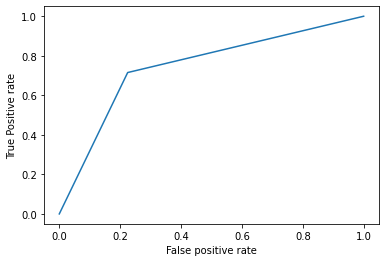

In [ ]:
# Plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, rand_pred)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')

## Convolution Neural Network

CNNs are mostly prevalent in image classification, where the input is two dimensional pixel and color channel data in a process called feature learning. The same process can be applied to one dimensional sequences of data using a 1D CNN which are especially useful in deriving features from a fixed-length segment of the overall dataset.

This makes the 1D CNN a suitable approach for our data which is video signal data over a fixed time frame [158 frames per video]

In [ ]:
# Reshape data for easy digestion by the cnn
x_train_reshaped = np.expand_dims(x_train, axis=2)
x_train_reshaped.shape

(1896, 4, 1)

In [ ]:
x_test_reshaped = np.expand_dims(x_test, axis=2)
x_test_reshaped.shape

(632, 4, 1)

In [ ]:
# Create model
cnn_model = Sequential()

cnn_model.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (4,1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(16, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1,activation = 'sigmoid'))

## Compile Model ##
optimizer = Adam(lr=0.00001)
cnn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Train Model and Check Validation Accuracy ##
cnn_model.fit(x_train_reshaped, y_train, validation_data = (x_test_reshaped,y_test), epochs = 500)

Epoch 1/500
60/60 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.5401 - val_loss: 0.6651 - val_accuracy: 0.5538
Epoch 2/500
60/60 [==============================] - 0s 2ms/step - loss: 0.6453 - accuracy: 0.5670 - val_loss: 0.6630 - val_accuracy: 0.5870
Epoch 3/500
60/60 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.5670 - val_loss: 0.6608 - val_accuracy: 0.6013
Epoch 4/500
60/60 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.5907 - val_loss: 0.6586 - val_accuracy: 0.6282
Epoch 5/500
60/60 [==============================] - 0s 2ms/step - loss: 0.6388 - accuracy: 0.5970 - val_loss: 0.6565 - val_accuracy: 0.6440
Epoch 6/500
60/60 [==============================] - 0s 2ms/step - loss: 0.6371 - accuracy: 0.5955 - val_loss: 0.6546 - val_accuracy: 0.6503
Epoch 7/500
60/60 [==============================] - 0s 2ms/step - loss: 0.6348 - accuracy: 0.5960 - val_loss: 0.6528 - val_accuracy: 0.6487
Epoch 8/500
6

In [ ]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2, 64)             256       
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
____________________________________________________

In [ ]:
cnn_pred = average(cnn_model.predict_classes(x_test_reshaped))
cnn_prob = cnn_model.predict_proba(x_test_reshaped)
accuracy = accuracy_score(y_test, np.array(cnn_pred))
roc = roc_auc_score(y_test, cnn_prob)
f1 = f1_score(y_test, cnn_pred)

print(f'Accuracy : {accuracy}, ROC : {roc}, F1_Score : {f1}')

Accuracy : 0.7072784810126582, ROC : 0.6926474122736741, F1_Score : 0.6580406654343808


In [ ]:
print(confusion_matrix(y_test, cnn_pred))

[[269  47]
 [138 178]]


## KNN

In [ ]:
# Determine the best k
accuracies = []
neighbors =  [x for x in range(6, 40)]
for i in neighbors:
  knn = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
  knn_pred = average(knn.predict(x_test))
  acc = accuracy_score(y_test, knn_pred) 
  accuracies.append(acc)

Maximum accuracy of 0.7531645569620253 at k = 13


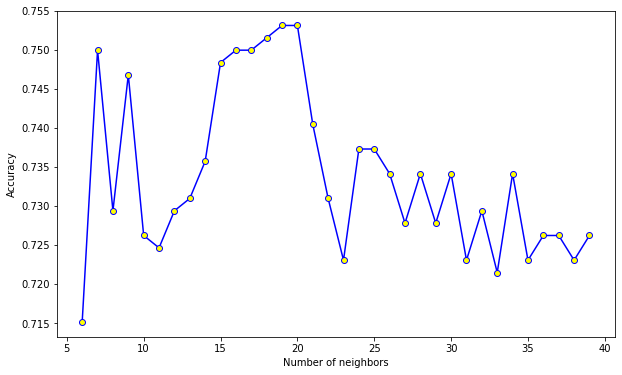

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(6,40), accuracies, color ='blue', marker = 'o', markerfacecolor='yellow')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
print(f'Maximum accuracy of {max(accuracies)} at k = {accuracies.index(max(accuracies))}')

In [ ]:
# Using k = 13
knn = KNeighborsClassifier(n_neighbors=13).fit(x_train, y_train)
knn_pred = average(knn.predict(x_test))
knn_prob = knn.predict_proba(x_test)[:, 1]

In [ ]:
# Confusion matrix
confusion_matrix(y_test, knn_pred)

array([[261,  55],
       [115, 201]])

In [ ]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       316
           1       0.79      0.64      0.70       316

    accuracy                           0.73       632
   macro avg       0.74      0.73      0.73       632
weighted avg       0.74      0.73      0.73       632



In [ ]:
# ROC score
print(f'ROC_AUC Score: {roc_auc_score(y_test,knn_prob)}')
print('F1 Score: ', f1_score(y_test, knn_pred))

ROC_AUC Score: 0.71927575709021
F1 Score:  0.7027972027972028


## XGBOOST

In [ ]:
# Initialize the xgboost classifier with base parameters
xgboost = XGBClassifier()
xgboost.fit(x_train, y_train)
xgb_pred = average(xgboost.predict(x_test))
xgb_prob = xgboost.predict_proba(x_test)[:, 1]

In [ ]:
# Classification report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       316
           1       0.70      0.71      0.71       316

    accuracy                           0.71       632
   macro avg       0.71      0.71      0.71       632
weighted avg       0.71      0.71      0.71       632



In [ ]:
xgboost.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
# confusion matrix
confusion_matrix(y_test, xgb_pred)

array([[222,  94],
       [ 92, 224]])

In [ ]:
# ROC Score
print('ROC AUC: ', roc_auc_score(y_test, xgb_prob))
print('F1 Score: ', f1_score(y_test, xgb_pred))

ROC AUC:  0.7310126582278481
F1 Score:  0.7066246056782334


In [ ]:
# Define parameter grid for parameter tuning
param_grid_xgb = {
    'max_depth': np.arange(80, 200, 10),
    'min_samples_leaf': [2,3],
    'n_estimators': [100, 200, 300, 500, 800]
}
# Perform cross validation
grid_search_xgb = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid_xgb, cv = 3, n_jobs = -1, verbose = 0, scoring='roc_auc')

In [ ]:
# Fit model
grid_search_xgb.fit(x_train, y_train)
print(grid_search_xgb.best_params_)
print(grid_search_xgb.best_score_)

{'max_depth': 80, 'min_samples_leaf': 2, 'n_estimators': 100}
0.701974176146985


In [ ]:
# Make predictions
improved_xgb = XGBClassifier(max_depth=80, min_samples_leaf=2, n_estimators=100).fit(x_train, y_train)
xgb_pred = average(improved_xgb.predict(x_test))
xgb_prob = improved_xgb.predict_proba(x_test)[:, 1]

In [ ]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       316
           1       0.69      0.70      0.69       316

    accuracy                           0.69       632
   macro avg       0.69      0.69      0.69       632
weighted avg       0.69      0.69      0.69       632



In [ ]:
print('ROC AUC score: ', roc_auc_score(y_test,xgb_prob))
print('F1 Score: ', f1_score(y_test, xgb_pred))

ROC AUC score:  0.7153000320461465
F1 Score:  0.6907378335949765
